## PyTorch implementation of Deep Bilteral Learning for Real Time Image Enhancement

In [66]:
from __future__ import division, print_function, unicode_literals
import numpy as np
from PIL import Image
import os, sys, glob
import cv2
import matplotlib.pyplot as plt
#Torch Imports
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

from tensorboardX import SummaryWriter

In [67]:
size = (256, 256)
batch_size = 100
learning_rate = 0.01
num_epochs = 5

# size of image, right now we are fixing this
x_size = 1920
y_size = 1080

# Constants for slicing layer
sx = 256.0/x_size
sy = 256.0/y_size
d  = 8

# tensorboard for pytorch stuff
writer = SummaryWriter()
sample_rate = 44100
freqs = [262, 294, 330, 349, 392, 440, 440, 440, 440, 440, 440]

# calculating Fx and keeping as constant from precomputation
x = range(x_size)
x = np.asarray(x, dtype=np.float64)
one = np.ones(x_size)
x = np.stack((x, one), axis=1)
x[:, 0] = x[:, 0]*sx
i  = range(16)
i  = np.asarray(i, dtype=np.float64)*-1
one= np.ones(16)
i = np.stack((one, i), axis=1).swapaxes(0, 1)
fx = torch.from_numpy(x)
i  = torch.from_numpy(i)
fxi= torch.matmul(fx, i)
fxi= torch.abs(fxi)
print(fxi.shape)

# calculating Fy and keeping as constant from precomputation
y = range(y_size)
y = np.asarray(y, dtype=np.float64)
one = np.ones(y_size)
y = np.stack((y, one), axis=1)
y[:, 0] = y[:, 0]*sy
y = y.swapaxes(0, 1)
i  = range(16)
i  = np.asarray(i, dtype=np.float64)*-1
one= np.ones(16)
i = np.stack((one, i), axis=1)
fy = torch.from_numpy(y)
i  = torch.from_numpy(i)
fyi= torch.matmul(i, fy)
fyi= torch.abs(fyi)
print(fyi.shape)
print(fyi.size())

torch.Size([1920, 16])
torch.Size([16, 1080])
torch.Size([16, 1080])


In [68]:
class Dataset(data.Dataset):
    def __init__(self, root_dir, train, transform=None):
        #Init Function
        super(Dataset, self).__init__()
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        
        self.full_res = []
        self.low_res = []
        self.truth = []
        
        if (train):
            dir = self.root_dir + '/train/'
        else :
            dir = self.root_dir + '/test/'
        
#         for img_path in glob.glob (dir + '*.jpg'):
        for img_path in glob.glob (dir +'input/' '*.tif'):
            img_name = img_path.split('/')[-1]
            print (img_name)
#             himage = Image.open (img_path)
#             himage = himage.resize (img_w,img_h)           
#             limage = himage.resize (size)           
#             output = Image.open(dir+'output/'+img_name)
#             output = output.resize(img_w,img_h)

            himage = cv2.imread (img_path)
            print(himage.shape)
            himage = cv2.resize (himage,(x_size, y_size))
            print(himage.shape)
            limage = cv2.resize (himage,size)
            output = cv2.imread (dir+'output/'+img_name)
            output = cv2.resize (output,(x_size, y_size))

            
            self.full_res.append (himage)
            self.low_res.append (limage)
            self.truth.append (output)

    def __len__(self):
        #Length function ?
        return len(self.full_res)

    def __getitem__(self, idx):
        #Accessor Function
        if self.transform is None:
            return (self.full_res[idx],self.low_res[idx])
        else:
            limg_transformed = self.transform(self.low_res[idx])
            himg_transformed =  self.transform(self.full_res[idx])
            truth_transformed = self.transform(self.truth[idx])
            return (himg_transformed, limg_transformed, truth_transformed)
       

In [69]:
composed_transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = Dataset (root_dir = '../data', train = True, transform = composed_transform)
train_dataset = Dataset (root_dir = '../dataset', train = True, transform = composed_transform)
# test_dataset = Dataset (root_dir = '../dataset', train = False, transform = composed_transform)
# im, im2, im3 = train_dataset.__getitem__(0)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

a0001-jmac_DSC1459.tif
(2000, 3008, 3)
(1080, 1920, 3)
a0004-jmac_MG_1384.tif
(2912, 4368, 3)
(1080, 1920, 3)


In [70]:
class LocalFeatureNet (nn.Module):

    def slicing_relu(self, F):
        #Function similar to custom relu does the tau calculation
        dimension = F.size()
        F_temp = F.cuda()
        F_temp = torch.ones(dimension).cuda().sub_(torch.abs(F_temp).float())
        F_temp = F_temp.cpu().numpy()
        F_temp[F_temp < 0] = 0
        F_temp = torch.from_numpy(F_temp)
        return F_temp
    
    def __init__(self):
        super (LocalFeatureNet, self).__init__()
        
        self.relu  = nn.ReLU (inplace = True)
        
        self.conv1 = nn.Conv2d (in_channels = 3,   out_channels = 8, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d (in_channels = 8,  out_channels = 16,  kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d (in_channels = 16, out_channels = 32,  kernel_size= 3, stride = 2,padding = 1)
        self.conv4 = nn.Conv2d (in_channels = 32, out_channels = 64,  kernel_size = 3, stride = 2, padding = 1)
        
        
        self.localconv1 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size = 3, stride = 1, padding = 1)
        self.localconv2 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size= 3, stride = 1, padding = 1)
        
        self.globalconv1 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size = 3, stride = 2,padding = 1)
        self.globalconv2 = nn.Conv2d (in_channels = 64, out_channels = 64,  kernel_size = 3, stride = 2, padding = 1)
        
        self.globalfc1 = nn.Linear (1024, 256)
        self.globalfc2 = nn.Linear (256, 128)
        self.globalfc3 = nn.Linear (128, 64)
        self.linear = nn.Conv2d(in_channels = 64, out_channels = 96,  kernel_size = 1, stride = 1)
        
        # Pixel Wise Network
        self.pixelwise_bias = nn.Parameter (torch.rand(3, 1), requires_grad=True)
        self.pixelwise_weight = nn.Parameter (torch.eye(3), requires_grad = True)
        self.pixelwise_obias = nn.Parameter (torch.eye(1), requires_grad = True)
        
        self.relu_slopes = nn.Parameter(torch.rand(3,16), requires_grad = True)
        self.relu_shifts = nn.Parameter(torch.rand(16,3), requires_grad = True)
        
        # Thing we do for upsampling
        self.Fx = fxi
        self.Fy = fyi
        self.Fx = self.slicing_relu(self.Fx).cuda()
        self.Fy = self.slicing_relu(self.Fy).cuda()
        
        
    def custom_relu(self,channel,value):
        print("value",value.size())
        size = (16,value.size()[0],value.size()[1],value.size()[2])
        size_alt = (1L,value.size()[0],value.size()[1],value.size()[2])
        print("size: ",size,"size_alt",size_alt)
        value = value.expand(size)
        
#         print(self.relu_shifts[:,channel])
        a = self.relu_shifts[:,channel].clone()
        a = a.view(16,1,1,1)
#         print(a.data,a)
#         value = self.relu(value - a.repeat(size_alt))    
# Upper line is not working for some damn reason so I hard coded it for now.
#         print ("here ", a.repeat(1,1,img_h,img_w).size())
        value = self.relu(value - a.repeat(size[1],1, x_size, y_size))
        print("st ", value.size())
        print ("st2 ", self.relu_slopes.size())
        value = self.relu_slopes.matmul(value.view(x_size, y_size,16,-1))
        print ("stt ", value.size())
        value = value.view(-1,3, x_size, y_size)
        value = value[:,1,:,:]+value[:,2,:,:]+value[:,0,:,:]
        print ("stt2 ", value.size())
        return value
    
    def upsample(self, grid, bilat):
        
        #### Making G
        g = grid.cuda()
        a = bilat.cuda()
        print(type(bilat))
        G = g.data
        print(type(G))
        G = d*G
        one = torch.ones(G.shape).cuda()
        print(type(one))
        G = torch.stack([G, one], 3)
        print(G.shape)
        one = torch.ones(8)
        K = torch.range(0, 7).cuda()* -1
        one= torch.ones(8).cuda()
        K = torch.stack((K, one), 1).permute(1, 0)
        z = K[0]
        K[0] = K[1]
        K[1] = z
#         G = torch.from_numpy(G)
        F_gk = torch.matmul(G, K)
        F_g = self.slicing_relu(F_gk)
        print("**********************")
        print(F_gk.size())
        print(F_g.size())
        print("**********************")
        #########################################
        
        print(a.data.size())
        A_temp = a.data.permute(0, 2, 3, 1, 4, 5)
        F_prod = torch.matmul(self.Fx, A_temp)
        F_prod = torch.matmul(F_prod, self.Fy)
        print("**********************")
        print(F_prod.size())
        print("**********************")
        F_prod_sum = F_prod.sum(3)
        print("$$$$$$$$$$$$$$$")
        print(F_prod_sum.size())
        print("**********************")
        a.data = F_prod_sum
        return F_prod_sum
        
        
        
    def output(self, grid, inp):
        out = torch.rand(inp.size()[0], y_size, x_size, 3).cuda()
        out = 0 * out
        grid = grid.view(-1, y_size, x_size, 12)
        
        for i in range(0,3):
            out[:,:,:,i] = out[:,:,:,i].add_(grid[:,:,:,3+4*i])
            for j in range(0,3):
#                 print(grid[:,:,:,j+4*i].size())
#                 print(inp[:,j,:,:].size())
                a = torch.autograd.Variable(grid[:,:,:,j+4*i], requires_grad=False)
#                 a = a.numpy()
                b = inp[:,j,:,:]
#                 b = b.numpy()
                temp = a.data * b.data
#                 print(temp.size())
                out[:,:,:,i] = out[:,:,:,i] + temp
        
        return out
    
    def forward (self, h, l):
        
        x = self.relu (self.conv1 (l))
        x = self.relu (self.conv2 (x))
        x = self.relu (self.conv3 (x))
        x = self.relu (self.conv4 (x))
        y = self.localconv1 (x)
        y = self.localconv2 (y)
        z = self.globalconv1 (x)
        z = self.globalconv2 (z)
        z = self.globalfc1 (z.view(z.size()[0], -1))
        z = self.globalfc2 (z)
        z = self.globalfc3 (z)
        fused = self.relu(z.view(-1,64,1,1)+y)
        lin = self.linear(fused)
        bilat = lin.view(-1, 8, 3, 4, 16, 16)
#         print (bilat.size())

# pixel wise network
        for i in range(0,3):
            a = self.pixelwise_weight[i,:].view(-1,3)
            b = h.unsqueeze(0).view(3,-1)
#             print(a.size(),b.size())
            p = torch.mm(a,b)
#             print(p.size())
            p = p.view(h.size()[0],h.size()[2],h.size()[3]) + self.pixelwise_bias[i]
#             print(p.size())
#             p = torch.bmm(self.pixelwise_weight[i,:], h.unsqueeze(0).view(3,-1)).view(h.size()) + self.pixelwise_bias[i]
#             print(i)
            p += self.custom_relu(i,p)
        p += self.pixelwise_obias
#         print(p.size())
        grid = p
#         print("+++++++++++++++++++")
#         print(bilat.size())
#         print("+++++++++++++++++++")
        print(grid.size())
        bilat_new = self.upsample(grid, bilat)
        #p is modified for tensorboard
        p = p.view(p.size()[0],1,p.size()[1],p.size()[2])
        writer.add_image('gridmap', p)
        return self.output(bilat_new,h)
        
        

In [71]:
model = LocalFeatureNet() 

# Add code for using CUDA here if it is available
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    model.cuda()

# Loss function and optimizers
criterion = torch.nn.MSELoss()# Define MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)# Use Adam optimizer, use learning_rate hyper parameter

In [72]:
def train():
    # Code for training the model
    # Make sure to output a matplotlib graph of training losses
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (himage, limage, truth) in enumerate(train_loader):  
            
            # Convert torch tensor to Variable
            himage = Variable(himage)
            limage = Variable(limage)
            truth = Variable(truth)
            if(use_gpu):
                himage=himage.cuda()
                limage=limage.cuda()
                truth = truth.cuda()
            
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(himage, limage)
            writer.add_image('himage', himage)
            writer.add_image('limage', limage)
            writer.add_image('truth',truth)
            writer.add_image('output', outputs.view(-1,3, y_size, x_size))
            loss = criterion(outputs, truth)
            
            model.pixelwise_obias.backward()
            
            model.pixelwise_bias[0,0].backward()
            model.pixelwise_bias[1,0].backward()
            model.pixelwise_bias[2,0].backward()
            
            model.pixelwise_weight[0,0].backward()
            model.pixelwise_weight[0,1].backward()
            model.pixelwise_weight[0,2].backward()
            model.pixelwise_weight[1,0].backward()
            model.pixelwise_weight[1,1].backward()
            model.pixelwise_weight[1,2].backward()
            model.pixelwise_weight[2,0].backward()
            model.pixelwise_weight[2,1].backward()
            model.pixelwise_weight[2,2].backward()
            
            for i in range(3):
                for j in range(16):
                    model.relu_slopes[i,j].backward()
                    model.relu_shifts[j,i].backward()
                    
#             loss.backward()
            optimizer.step()
            loss_arr.append(loss.data[0])
            writer.add_scalar('loss',loss.data[0])
            if (i+1) % batch_size == 0:       
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

value torch.Size([2, 1080, 1920])
size:  (16, 2L, 1080L, 1920L) size_alt (1L, 2L, 1080L, 1920L)
st  torch.Size([16, 2, 1080, 1920])
st2  torch.Size([3, 16])
stt  torch.Size([1920, 1080, 3, 2])
stt2  torch.Size([2, 1920, 1080])
value torch.Size([2, 1080, 1920])
size:  (16, 2L, 1080L, 1920L) size_alt (1L, 2L, 1080L, 1920L)
st  torch.Size([16, 2, 1080, 1920])
st2  torch.Size([3, 16])
stt  torch.Size([1920, 1080, 3, 2])
stt2  torch.Size([2, 1920, 1080])
value torch.Size([2, 1080, 1920])
size:  (16, 2L, 1080L, 1920L) size_alt (1L, 2L, 1080L, 1920L)
st  torch.Size([16, 2, 1080, 1920])
st2  torch.Size([3, 16])
stt  torch.Size([1920, 1080, 3, 2])
stt2  torch.Size([2, 1920, 1080])
torch.Size([2, 1080, 1920])
<class 'torch.autograd.variable.Variable'>
<class 'torch.cuda.FloatTensor'>
<class 'torch.cuda.FloatTensor'>
torch.Size([2, 1080, 1920, 2])


/home/eeshangd/vision_env/lib/python2.7/site-packages/ipykernel_launcher.py:88: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].


**********************
torch.Size([2, 1080, 1920, 8])
torch.Size([2, 1080, 1920, 8])
**********************
torch.Size([2, 8, 3, 4, 16, 16])
**********************
torch.Size([2, 3, 4, 8, 1920, 1080])
**********************
$$$$$$$$$$$$$$$
torch.Size([2, 3, 4, 1920, 1080])
**********************
value torch.Size([2, 1080, 1920])
size:  (16, 2L, 1080L, 1920L) size_alt (1L, 2L, 1080L, 1920L)
st  torch.Size([16, 2, 1080, 1920])
st2  torch.Size([3, 16])
stt  torch.Size([1920, 1080, 3, 2])
stt2  torch.Size([2, 1920, 1080])
value torch.Size([2, 1080, 1920])
size:  (16, 2L, 1080L, 1920L) size_alt (1L, 2L, 1080L, 1920L)
st  torch.Size([16, 2, 1080, 1920])
st2  torch.Size([3, 16])
stt  torch.Size([1920, 1080, 3, 2])
stt2  torch.Size([2, 1920, 1080])
value torch.Size([2, 1080, 1920])
size:  (16, 2L, 1080L, 1920L) size_alt (1L, 2L, 1080L, 1920L)
st  torch.Size([16, 2, 1080, 1920])
st2  torch.Size([3, 16])
stt  torch.Size([1920, 1080, 3, 2])
stt2  torch.Size([2, 1920, 1080])
torch.Size([2, 1080, 1

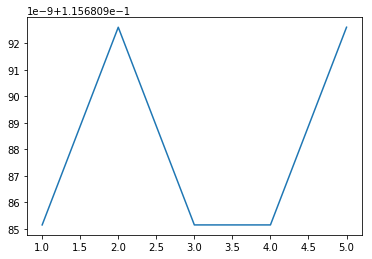

CPU times: user 39.7 s, sys: 3.2 s, total: 42.9 s
Wall time: 28.5 s


In [73]:
%time train()

In [74]:
# torch.save(model.state_dict(), 'model.pkl')

In [ ]:
# model.load_state_dict(torch.load('model.pkl'))
def train():
    # Code for training the model
    # Make sure to output a matplotlib graph of training losses
    loss_arr = []
    for i, (himage, limage, truth) in enumerate(test_loader):  

        # Convert torch tensor to Variable
        himage = Variable(himage)
        limage = Variable(limage)
        truth = Variable(truth)
        if(use_gpu):
            himage=himage.cuda()
            limage=limage.cuda()
            truth = truth.cuda()


        outputs = model(himage, limage)
        writer.add_image('test/himage', himage)
        writer.add_image('test/limage', limage)
        writer.add_image('test/truth',truth)
        writer.add_image('test/output', outputs.view(-1,3, y_size, x_size))
        loss = criterion(outputs, truth)

        loss_arr.append(loss.data[0])
        writer.add_scalar('test/loss',loss.data[0])
    
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

In [75]:
# writer.export_scalars_to_json("./all_scalars.json")
writer.close()